In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings(action = 'ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

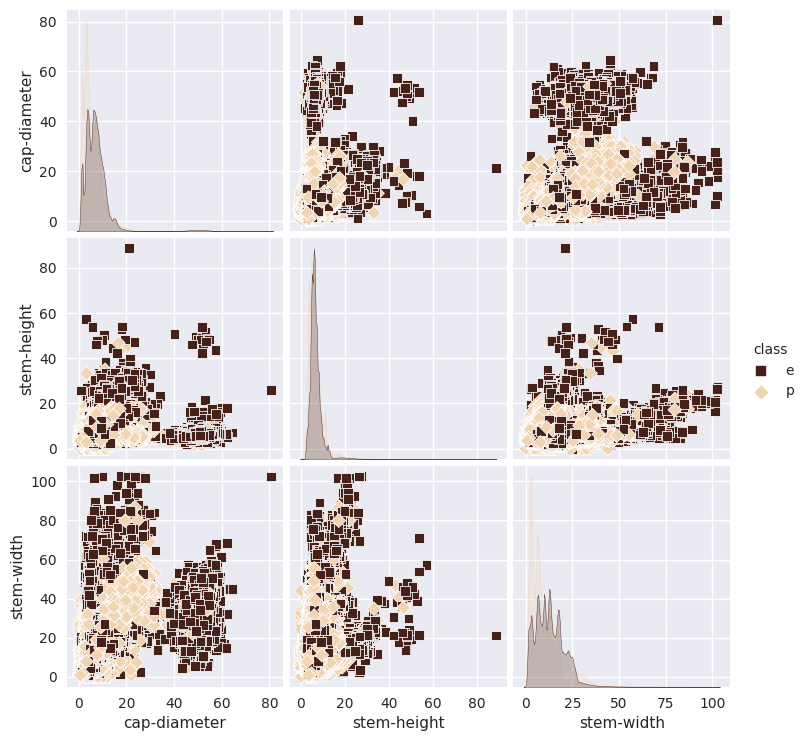

In [4]:
import seaborn as sns 
import matplotlib.pyplot as plt 

plt.style.use("seaborn")

num = train[['cap-diameter', 'stem-height', 'stem-width', 'class']]

sns.pairplot(num, hue = 'class', palette=['#462119', '#f1d4b2'], 
             diag_kind='kde', markers=['s', 'D'])
plt.show()

From this pairplot, it seems like an interaction term between the `cap-diameter` and `stem-width` may yield positive results. Additionally, `cap-diameter` and `stem-height` look positive as well. 

In [5]:
from sklearn.metrics import mutual_info_score 

def generate_mi_scores(categorical, response):
    mi_scores = []
    
    for feature_name in categorical: 
        # Ignore the response...
        if feature_name == response.name: 
            continue 

        # Drop missing values
        processed = categorical[[feature_name, response.name]]
        processed = processed.dropna()
        
        feature = processed[feature_name]
        response = processed[response.name]
        
        mi = mutual_info_score(feature, response)
        mi_percentage = round(mi * 100, 2) 
        
        mi_scores.append(mi_percentage)
        
    feature_names = list(categorical.drop('class', axis=1))
    mi_scores_table = pd.DataFrame({
        "feature": feature_names,
        "mutual-info": mi_scores
    })
    
    return mi_scores_table

cat = train.select_dtypes(include='object')
response = cat['class']

mutual_info = generate_mi_scores(cat, response)
mutual_info = mutual_info.sort_values(by='mutual-info', ascending=False)

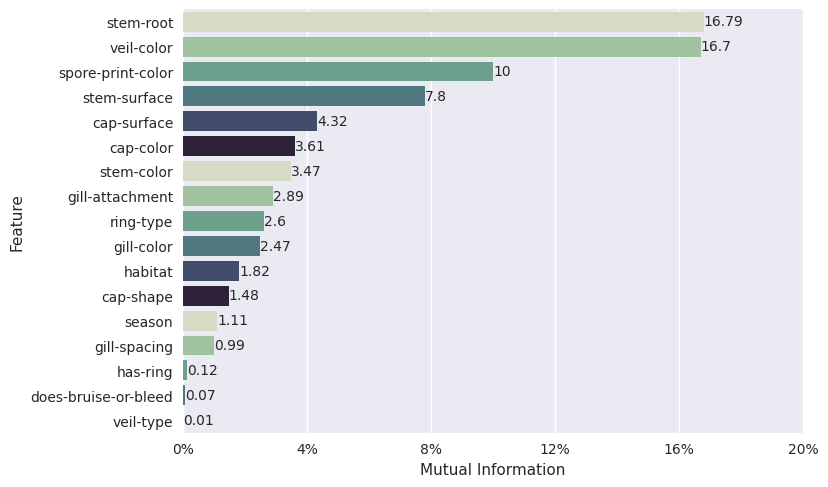

In [6]:
palette = sns.cubehelix_palette(start=.5, rot=-.75)
graph = sns.barplot(mutual_info, x='mutual-info', y='feature', orient='h', palette=palette)

graph.set_ylabel('Feature')
graph.set_xlabel('Mutual Information')

xticks = np.arange(0, 24, 4)
xlabels = [f'{x}%' for x in xticks]
graph.set_xticks(xticks, labels=xlabels)

for container in graph.containers:
    graph.bar_label(container)
    
plt.show()

Let's find the most influential labels among the top 4 categories

In [7]:
def get_influential_labels(feature, max_observ):
    """
    Obtain labels with more than 
    a specified number of observations.
    """
    
    category_counts = feature.value_counts()
    labels = category_counts[category_counts > max_observ].index.tolist()
    
    return labels 

def map_to_influential_labels(dataframe, response):
    """
    This function maps only the significant
    labels for each feature, setting the rest
    to NaN. The dataframe provided must include
    only categorical features.
    """
    
    max_observ = 500 
    
    for feature in dataframe: 
        if feature == response: 
            continue 
            
        labels = get_influential_labels(dataframe[feature], max_observ)
        
        dataframe[feature] = dataframe[feature].map(lambda x: x if x in labels else None)

    return dataframe

cat = train.select_dtypes(include='object')
cat = map_to_influential_labels(cat, 'class')

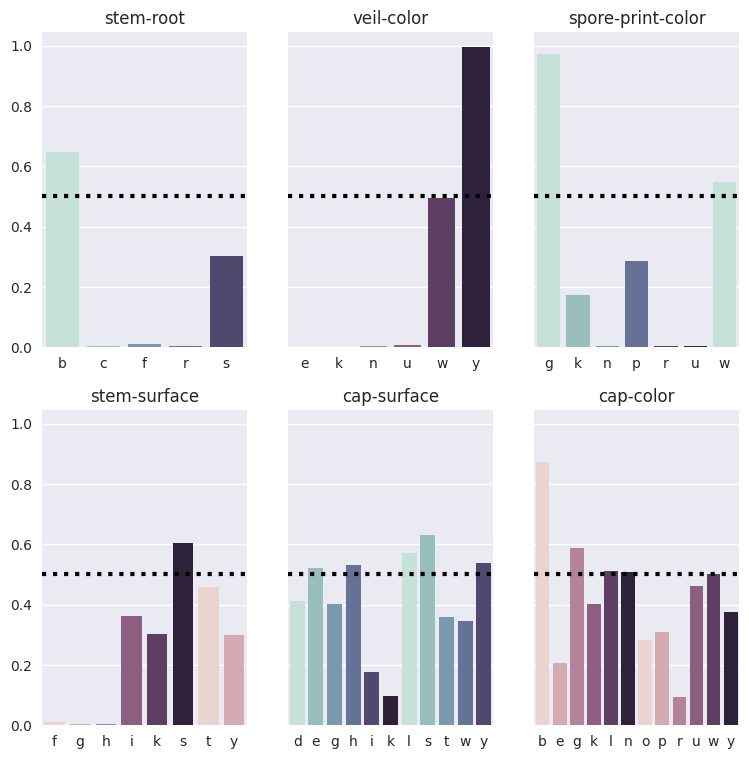

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(9, 9), sharey=True)
blue_palette = sns.cubehelix_palette(start=.5, rot=-.5)
purple_palette = sns.cubehelix_palette()

def influential_label_plots(dataframe, response, max_col):
    row, col = 0, 0
    is_blue_palette = True
    palette = blue_palette if is_blue_palette else purple_palette 
    
    for feature in dataframe: 
        if feature == response:
            return
        
        palette = blue_palette if is_blue_palette else purple_palette 
        
        class_proportions = dataframe.groupby(feature)[response].mean()
        graph = axes[row, col]
        
        sns.barplot(ax=graph, palette=palette,
                    x=class_proportions.index, y=class_proportions.values)
        graph.axhline(y=0.50, linewidth=3, color='black', ls=':')
        
        graph.set_title(feature)
        graph.set_xlabel('')
        
        is_blue_palette = not is_blue_palette
        
        col += 1
        
        if col == max_col: 
            col = 0
            row += 1 
    
# Select the top 6 features based on MI scores
top_cat_features = mutual_info['feature'].iloc[:6, ].values.tolist()
new_cat = cat[top_cat_features]

new_cat['class'] = train['class'].apply(lambda x: 1 if x == 'e' else 0)

influential_label_plots(new_cat, 'class', 3)        